# Get started with GRASS & Python in Jupyter Notebooks

Veronica Andreo  
2024-03-25

Python, a widely used general-purpose, high-level programming language
provides a powerful scripting interface for geospatial data processing.
Being easy-to-use yet powerful, it enables users to efficiently exploit
the capabilities of the GRASS software. Python scripts for GRASS can be
written at high level (GRASS tools) as well as at low level (GRASS
libraries) through dedicated interfaces. Indeed, GRASS is distributed
with a set of [python
packages](https://grass.osgeo.org/grass-stable/manuals/libpython/index.html)
to provide functionalities at different levels.

In this tutorial, we will focus on two packages:
[`grass.script`](https://grass.osgeo.org/grass-stable/manuals/libpython/script_intro.html)
and
[`grass.jupyter`](https://grass.osgeo.org/grass-stable/manuals/libpython/grass.jupyter.html),
which provide Python interface to launch GRASS tools in scripts and
offer classes and setup functions for running GRASS in Jupyter
Notebooks, respectively. We will show two different use cases:

-   A. You are mostly a Python user and only need to run a certain GRASS
    tool on your spatial data to get a specific output
-   B. You are mostly a GRASS user that wants to use GRASS from a Python
    environment or combine GRASS with other Python packages.

Let’s first go through the main functions of GRASS Python packages.

### Python package `grass.script`

The **grass.script** package or GRASS Python Scripting Library provides
functions for calling GRASS tools within Python scripts. The most
commonly used functions include:

-   `run_command`: used when there is no text output or the text output
    does not need to be further processed
-   `read_command`: used when the output of the tools is of text type
-   `parse_command`: used with tools that output machine readable text
    output
-   `write_command`: used with tools that expect text input, either in
    the form of a file or from stdin

There are several wrapper functions for frequently used tools, too. For
example:

-   To get info from a raster, script.raster.raster_info() is used:
    `gs.raster_info('dsm')`
-   To get info of a vector, script.vector.vector_info() is used:
    `gs.vector_info('roads')`
-   To list the raster in a project, script.core.list_grouped() is used:
    `gs.list_grouped(type=['raster'])`
-   To obtain the computational region, script.core.region() is used:
    `gs.region()`
-   To run raster algebra with r.mapcalc, script.raster.mapcalc() is
    used: `gs.mapcalc()`

The grass.script package also comes with different functions that are
useful when you are writing your own GRASS tools or converting your
scripts or workflows into GRASS tools. Some examples of these functions
are: `append_uuid`, `use_temp_region`, `del_temp_region`,
`parse_key_val`, etc.

> **Note**
>
> Visit the grass.script documentation for more details and examples:
> <https://grass.osgeo.org/grass-stable/manuals/libpython/script_intro.html>

### Python package `grass.jupyter`

The **grass.jupyter** library improves the integration of GRASS and
Jupyter, and provides different classes to facilitate GRASS maps
visualization:

-   `Map`: 2D rendering
-   `Map3D`: 3D rendering
-   `InteractiveMap`: interactive map visualization with folium or
    ipyleaflet
-   `SeriesMap`: visualizations of a series of raster or vector maps
-   `TimeSeriesMap`: visualization of space-time datasets

> **Note**
>
> Visit the grass.jupyter documentation for more details and examples:
> <https://grass.osgeo.org/grass-stable/manuals/libpython/grass.jupyter.html>

## Let’s get started!

### Setup

This tutorial can be run locally. You need to have **GRASS 8.4+** and
**Jupyter** installed. For part A, please download these [Sentinel
2](https://grass.osgeo.org/sampledata/north_carolina/nc_sentinel_utm17n.zip)
scenes and move the unzipped download into the directory where you are
running this tutorial. For part B, we asume that you have downloaded the
North Carolina [sample
dataset](https://grass.osgeo.org/sampledata/north_carolina/nc_basic_spm_grass7.zip),
i.e., there’s an existing GRASS project. Be sure you also have the
following Python libraries installed in your environment: `folium` or
`ipyleaflet`, `numpy`, `seaborn`, `matplotlib`, `pandas`.

The first thing we need to do is to *import GRASS python packages*. In
order to do so, we need to *add GRASS python package to PATH*. Let’s see
how we do that.

In [1]:
# import standard Python packages
import os
import sys
import subprocess
from pathlib import Path

In [2]:
# check where GRASS python packages are and add them to PATH
sys.path.append(
    subprocess.check_output(["grass", "--config", "python_path"], text=True).strip()
)

In [3]:
# import GRASS python packages
import grass.script as gs
import grass.jupyter as gj

> **Note**
>
> We recommend Windows users to review how to run [GRASS in Jupyter
> Notebooks on Windows](JupyterOnWindows_OSGeo4W_Tutorial.qmd).

### A. Use GRASS tools within your Python spatial workflows

Now, let’s assume you have some raster data you want to process with
GRASS tools, eg. Sentinel 2 satellite data, to obtain texture indices.
The first thing you’ll need to do is to **create a GRASS project** to
import your data. As we saw already in a previous [fast
track](fast_track.qmd) tutorial, GRASS projects are folders where we
store spatial data with the same spatial reference. These projects can
be placed wherever you want, including a temporary directory if you are
mostly interested in the outputs only.

So, let’s *create a project in a temporary directory* to import,
i.e. read, our data with GRASS. The `gs.create_project()` function
allows us to create a GRASS project passing different information. For
example, we can use the EPSG code of the data CRS or directly pass a
georeferenced file.

In [4]:
# Create a temporary folder where to place our GRASS project
import tempfile
tempdir = tempfile.TemporaryDirectory()

In [5]:
# Create a project in the temporary directory
gs.create_project(path=tempdir.name,
                  name="nc_sentinel",
                  epsg="32617")

Alternatively, use a georeferenced file to read the spatial reference
information from:

In [6]:
# gs.create_project(path=tempdir.name, name="nc_sentinel", filename="path/to/georef/file", overwrite=True)

Now that we created a project, let’s **start a GRASS** session there.

In [7]:
# Start GRASS in the recently created project
session = gj.init(Path(tempdir.name, "nc_sentinel"))

We are now ready to **import data** into the recently created project.
Let’s use a for loop to import all 10 m resolution bands. These are
level 2A surface reflectance data for blue, green, red and near infrared
Sentinel 2 bands.

In [8]:
import shutil

shutil.unpack_archive("./nc_sentinel_utm17n/S2A_MSIL2A_20220304T160151_N0400_R097_T17SQV_20220304T215812.zip", "./nc_sentinel_utm17n")
files = sorted(Path('./nc_sentinel_utm17n/S2A_MSIL2A_20220304T160151_N0400_R097_T17SQV_20220304T215812.SAFE/GRANULE/L2A_T17SQV_A034986_20220304T160221/IMG_DATA/R10m').glob('*B*.jp2'))
files

In [9]:
for file in files:
    name = str(file)[-11:-4]
    print("importing " + name)
    gs.run_command("r.import", input=file, output=name)

Let’s check the files we just imported are there:

In [10]:
gs.list_grouped(type="raster")["PERMANENT"]

Let’s have a quick look at one of the imported bands. We can use the
`InteractiveMap` class from the grass.jupyter package to **visualize**
it.

In [11]:
m = gj.InteractiveMap()
m.add_raster("B08_10m")
m.show()

Next step is to do some **processing or analysis** with the imported
data. Since we’ll be creating new raster maps, we first need to set our
*computational region* to the extent and resolution of one of our
imported bands.

In [12]:
# Set computational region
gs.run_command("g.region", raster="B08_10m", flags="p")

In [13]:
m = gj.InteractiveMap(tiles="OpenStreetMap")
m.add_raster("B08_10m")
m.show()

It is common to estimate texture measures over panchromatic bands. Since
we do not have one in Sentinel 2 data, we’ll create a synthetic one by
averaging blue, green and red bands.

In [14]:
# Create synthetic pan band
gs.mapcalc("pan = (B02_10m + B03_10m + B04_10m) / 3")

Now that we have the synthetic pan band, let’s estimate some texture
measures with the
[r.texture](https://grass.osgeo.org/grass-stable/manuals/r.texture.html)
tool.

In [15]:
gs.run_command("r.texture",
              input="pan",
              output="pan",
              size=5,
              method="contrast,corr")

In [16]:
gs.list_grouped(type="raster", pattern="pan*")["PERMANENT"]

In [17]:
t = gj.InteractiveMap(tiles="OpenStreetMap")
t.add_raster("pan_Contr")
t.add_raster("pan_Corr")
t.show()

Finally, we can **export** our texture maps out of GRASS and use them
somewhere else or load them into a webGIS.

In [18]:
texture_maps = gs.list_grouped(type="raster", pattern="pan_*")["PERMANENT"]
texture_maps

In [19]:
for texture in texture_maps:
    gs.run_command("r.out.gdal", input=texture, output=f"{texture}.tif", format="GTiff")

This use case follows the Extract-Transform-Load (ETL) process common in
production systems. Indeed, this approach allows to include GRASS tools
into such workflows. These type of tasks could be automatized in scripts
to be run without even starting GRASS using the `--exec` tool… but
that’s material for a different tutorial :)

### B. Use Python tools within GRASS workflows

This case is more relevant for GRASS users who want to combine GRASS
with other Python tools for their data processing and analysis
workflows.

Several GRASS users store most or all of their projects in a single
folder, which has traditionally been called `grassdata`. When this is
the case, to **start GRASS in an existing project**, we also need to
provide the path to such a folder.

In [20]:
# Start GRASS
session = gj.init("~/grassdata/nc_basic_spm_grass7/PERMANENT")
# alternatively
# session = gj.init("~/grassdata/nc_basic_spm_grass7")
# session = gj.init("~/grassdata", "nc_basic_spm_grass7", "PERMANENT")

We are now within a GRASS project, let’s **obtain information** about
it, like CRS details, region settings, list of raster and vector maps,
etc.

In [21]:
# Print project's CRS
gs.parse_command("g.proj", flags="g")["srid"]

In [22]:
# Print computational region
gs.region()

In [23]:
# List raster maps
gs.list_grouped(["raster"])

Let’s obtain metadata about the *elevation* raster map.

In [24]:
# Raster info
gs.raster_info("elevation")

If we would only need to know or use the minimum value of the
*elevation* raster, we can get it as follows:

In [25]:
gs.raster_info("elevation")["min"]

Let’s now **visualize** raster and vector maps with a different
`grass.jupyter` class, the non-interactive `Map` class. This class
creates and displays GRASS maps as PNG files. We basically instantiate
the class first, add maps and maps’ elements and finally show the
result. There are 2 ways of calling display (`d.*`) modules:

-   replace `.` by `_` as in `m.d_rast()`
-   use `run()` as in `m.run("d.rast")`

In [26]:
# Instantiate the Map class
m = gj.Map(width=400)

The *Map* class will by default use the first raster or vector extent to
set the display extent. You could however also use the current
computational region with `use_region=True` or call a previously saved
computational region (different than the current) with the argument
`saved_region`.

In [27]:
# Add maps and map elements
m.d_rast(map="elevation")
m.d_vect(map="streams")
m.d_legend(raster="elevation", at=(50, 95, 85, 90), flags="b")

In [28]:
# Display the result
m.show()

We can save our displayed maps by calling the `save()` method, i.e.,
`m.save()`. For the Map class it will output a PNG file, while for the
InteractiveMap class an HTML.

#### GRASS & NumPy

Let’s now see how to convert our **GRASS rasters into numpy arrays**.
Having our raster maps as numpy arrays opens up a world of possibilities
in terms of visualization and data analysis and modeling. We won’t go
into anything complex here, but we’ll show how to read rasters into
numpy arrays, plot them, modify them and then write them back into
GRASS.

In [29]:
# Import required libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from grass.script import array as garray

In [30]:
# Read elevation as numpy array
elev = garray.array(mapname="elevation", null="nan")
print(elev.shape)

In [31]:
# Estimate array average
print(np.average(elev))

In [32]:
# Plot elev histogram
sns.set_style('darkgrid')
sns.histplot(data=elev.ravel(), kde=True)

Let’s modify our array and write it back into GRASS. For this, we create
a new copy of the GRASS elevation map first as shown below.

In [33]:
elev_2 = garray.array(mapname="elevation")
elev_2 *= 2

In [34]:
# Plot elev*2
sns.histplot(data=[elev.ravel(), elev_2.ravel()], kde=True)
plt.legend(labels=["elevation * 2", "elevation"])

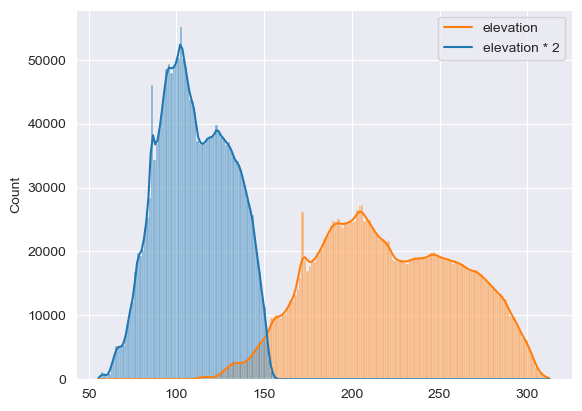

Now we write the modified array into a GRASS raster map and check it’s
actually there.

In [35]:
elev_2.write(mapname="elevation_2", overwrite=True)

In [36]:
gs.list_grouped(type="raster", pattern="elev*")

#### GRASS & Pandas

Let’s now explore how to convert text outputs into pandas data frames.
We will get elevation univariate statistics for each land use class and
parse the output into a pandas data frame.

In [37]:
import pandas as pd
from io import StringIO

In [38]:
stats = gs.read_command("r.univar",
                        flags="t",
                        map="elevation",
                        zones="landuse",
                        separator="comma")
df = pd.read_csv(StringIO(stats))

df

Next, we plot the mean elevation per class as follows:

In [39]:
plt.figure(figsize=(10, 5))
plt.bar(df['label'], df['mean'])
plt.ylabel('Elevation')
plt.title('Mean elevation by land cover type')
plt.xticks(rotation=90)
plt.show()

Similarly, if we need to do analysis with the attributes of GRASS vector
maps, it is also possible to read the attribute table as a pandas data
frame. Let’s see an example with the census vector map:

In [40]:
census = gs.parse_command("v.db.select", map="census", format="json")["records"]
df = pd.DataFrame(census)
df

Once the attribute table is a data frame, we can, e.g., filter data by a
condition and plot the results.

In [41]:
fam_size_3 = df[df["FAM_SIZE"] > 3.0]

In [42]:
fam_size_3.plot.scatter(x="FAM_SIZE", y="OWNER_U")

## Final remarks

In this tutorial, we have demonstrated, with very simple examples, how
to use GRASS tools together with Python, putting a special focus on data
import and export as well as format conversions. Expert GRASS or Python
users can then implement their workflows combining tools accordingly.

**Enjoy!**

------------------------------------------------------------------------

The development of this tutorial was funded by the US [National Science
Foundation (NSF)](https://www.nsf.gov/), award
[2303651](https://www.nsf.gov/awardsearch/showAward?AWD_ID=2303651).